# VHL proteomics cis comparison

## Step 1: Library Imports

Run this cell to import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
sys.path.append('C:\\Users\\brittany henderson\\GitHub\\WhenMutationsMatter\\Brittany\\')
import functions as f

import cptac
import cptac.algorithms as al

## Step 2: Find the frequently mutated genes for Kidney Cancer

Enter the type of cancer and the cutoff for mutation frequency that you would like to use.

In [2]:
rc_object = cptac.RenalCcrcc()
desired_cutoff = 0.1

renal_freq_mut = al.get_frequently_mutated(rc_object, cutoff = desired_cutoff)
renal_freq_mut.loc[renal_freq_mut['Gene'] == 'KDM5C']

,Gene,Unique_Samples_Mut,Missense_Mut,Truncation_Mut
1,KDM5C,0.172727,0.036364,0.145455


## Step 3: Select VHL, a frequently mutated gene

In [3]:
gene = 'VHL'

## Step 4: Select proteomics

In [4]:
omics = rc_object.get_proteomics()

## Step 5: cis comparison 

Determine if the DNA mutation has an effect on the omics measurement. In order to do this, we have a few steps in code. These steps are found in the format_cis_comparison_data function.
1. get a table with both the omics and mutation data for tumors
2. get a binary column from the mutation data to separate our samples
3. format data frame to be used in the T-test
4. send data to the T-test.

The format_cis_comparison_data does the first 3 steps.

In [5]:
rc_status = f.format_cis_comparison_data(rc_object, 'proteomics', gene)

In [6]:
omics_col_list = [gene+'_proteomics']
prot_col = gene+"_proteomics"

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison\n")
significant_pval_results = al.wrap_ttest(rc_status, 'binary_mutations', omics_col_list)
print(significant_pval_results)

Doing t-test comparison

No significant comparisons.
None


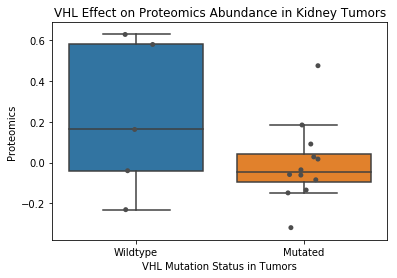

In [7]:
# Step 5 - Create boxplt to compare wildtype and mutated effect on omics data
cis_boxplot = sns.boxplot(data = rc_status, x = 'binary_mutations',
                          y = prot_col, order = ["Wildtype","Mutated"], showfliers = False)  
cis_boxplot.set_title(gene + " Effect on Proteomics Abundance in Kidney Tumors")
cis_boxplot = sns.stripplot(data= rc_status, x = 'binary_mutations',
                            y = prot_col,jitter = True, color = ".3", order = ["Wildtype","Mutated"])
cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
plt.show()
plt.clf()
plt.close()

Repeat the above steps this time comparing missense and truncation mutation types.

In [8]:
rc_type = f.get_missence_truncation_comparison(rc_object, 'proteomics', gene)

print("Doing t-test comparison\n")
significant_pval_results = al.wrap_ttest(rc_type, 'binary_mutations', omics_col_list)
print(significant_pval_results)

Doing t-test comparison

No significant comparisons.
None


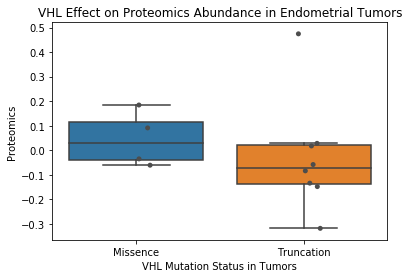

In [9]:
rc_cis_boxplot = sns.boxplot(data = rc_type, x = 'binary_mutations',
                          y = prot_col, order = ["Missence","Truncation"], showfliers = False)  
rc_cis_boxplot.set_title(gene + " Effect on Proteomics Abundance in Endometrial Tumors")
rc_cis_boxplot = sns.stripplot(data= rc_type, x = 'binary_mutations',
                            y = prot_col, jitter = True, color = ".3", order = ["Missence","Truncation"])
rc_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
plt.show()
plt.clf()
plt.close()

#  Compare common mutations

Find the common mutation types and compare them to the wildtype tumors.

In [10]:
# Count all mutations (including all mutations in a sample)
somatic_mutations = rc_object.get_mutations()
gene_mutations = somatic_mutations.loc[somatic_mutations['Gene'] == gene]
count_all_mut = gene_mutations['Mutation'].value_counts()
count_all_mut

Missense_Mutation    31
Frame_Shift_Del      23
Nonsense_Mutation    10
Frame_Shift_Ins       8
Splice_Site           8
In_Frame_Del          1
In_Frame_Ins          1
Name: Mutation, dtype: int64

In [11]:
# count real measurements of omics data 
mutation_prot = rc_object.join_omics_to_mutations(omics_df_name="proteomics",
                                                  mutations_genes=gene, 
                                                  omics_genes=gene)
tumors = mutation_prot.loc[mutation_prot['Sample_Status'] == 'Tumor']                                                  
measured_omics = tumors.dropna(axis=0)
counts = measured_omics[gene+'_Mutation'].value_counts()
counts

[Wildtype_Tumor]       5
[Missense_Mutation]    4
[Frame_Shift_Del]      3
[Nonsense_Mutation]    3
[Frame_Shift_Ins]      2
Name: VHL_Mutation, dtype: int64

In [12]:
common_mutations = counts[counts.apply(lambda x: x > 4)] # check mut (have data in more than 1 sample)
print(common_mutations)

common_mut_list = list(common_mutations.index) #list of lists
common_mut_list = [''.join(x) for x in common_mut_list] #list of strings
common_mut_list

[Wildtype_Tumor]    5
Name: VHL_Mutation, dtype: int64


['Wildtype_Tumor']

Not enough proteomics data for any common mutation to do a T-test.

# Visualize all Mutations

In [13]:
mutation_prot = rc_object.join_omics_to_mutations(omics_df_name="proteomics", mutations_genes=gene, 
                                                        omics_genes=gene,
                                                    mutations_filter=['Missense_Mutation'])

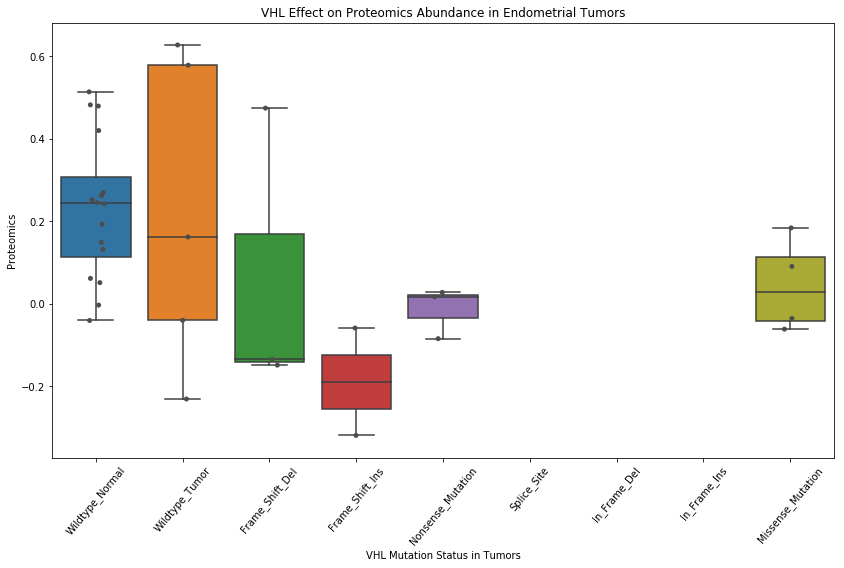

In [14]:
plt.rcParams['figure.figsize']=(14,8)
rc_cis_boxplot = sns.boxplot(data = mutation_prot,
                             x = gene+'_Mutation',
                             y = gene+'_proteomics', 
                             order=['Wildtype_Normal', 'Wildtype_Tumor', 'Frame_Shift_Del', 
                                    'Frame_Shift_Ins', 'Nonsense_Mutation', 'Splice_Site',
                                    'In_Frame_Del', 'In_Frame_Ins', 'Missense_Mutation'],
                             showfliers = False)  
rc_cis_boxplot.set_title(gene + " Effect on Proteomics Abundance in Endometrial Tumors")
rc_cis_boxplot = sns.stripplot(data= mutation_prot, 
                               x = gene+'_Mutation',
                               y = gene+'_proteomics', 
                               order=['Wildtype_Normal', 'Wildtype_Tumor', 'Frame_Shift_Del', 
                                    'Frame_Shift_Ins', 'Nonsense_Mutation', 'Splice_Site',
                                    'In_Frame_Del', 'In_Frame_Ins', 'Missense_Mutation'],
                               jitter = True, color = ".3")
rc_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
rc_cis_boxplot.set_xticklabels(rc_cis_boxplot.get_xticklabels(),rotation = 50)
plt.show()
plt.clf()
plt.close()

# Analysis of Results

No significant results. 